In [1]:
from llama_index.llms.groq import Groq
from llama_index.llms.openai import OpenAI
from llama_index.llms.gemini import Gemini
from llama_index.core import (
    VectorStoreIndex, 
    Settings, 
    StorageContext,
    load_index_from_storage,
    SimpleDirectoryReader
)
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from dotenv import load_dotenv, find_dotenv
import os
import openai

In [8]:
embed_model = HuggingFaceEmbedding(model_name= "BAAI/bge-small-en-v1.5")

Settings.embed_model = embed_model
Settings.llm = Groq(
    model="llama-3.1-8b-instant",
    api_key=os.environ.get("GROQ_API_KEY"),
)

storage_context = StorageContext.from_defaults(
    persist_dir = "./embedding/Advance_Rag"
)

vector_index = load_index_from_storage(
    storage_context, 
)

query_engine = vector_index.as_query_engine(similar_top_k = 6)

In [136]:
query = """
       Những biện pháp chăm sóc cần thiết tại phòng sinh cho trẻ sơ sinh là gì?
    """
response = query_engine.query(query)
print(response.source_nodes[0].get_text())
print("---------------------------------------------------")
print(response.response)

Hầu hết trẻ chỉ cần chăm sóc hỗ trợ thiết yếu ngay sau sinh:  Lau khô trẻ bằng khăn sạch.  Quan sát trẻ trong khi lau khô (xem lưu đồ 12).  Duy trì sự tiếp xúc da kề da giữa bé và mẹ.  Giữ ấm cho trẻ để tránh mất nhiệt.  Kẹp và cắt dây rốn tối thiểu 1 phút sau sinh.  Khuyến khích cho bú mẹ sớm trong vòng giờ đầu sau sinh. Phương pháp da kề da và nuôi con bằng sữa mẹ sớm là cách tốt nhất để ủ ấm và phòng ngừa hạ đường huyết cho trẻ. T rẻ sơ sinh đủ tháng và nhẹ cân (>1.200g) mà không kèm biến chứng và lâm sàng ổn định nên được tiếp xúc da kề da với mẹ càng sớm càng tốt, ngay sau khi lau khô để tránh hạ thân nhiệt.
---------------------------------------------------
Những biện pháp chăm sóc cần thiết tại phòng sinh cho trẻ sơ sinh bao gồm: lau khô trẻ bằng khăn sạch, quan sát trẻ trong khi lau khô, duy trì sự tiếp xúc da kề da giữa bé và mẹ, giữ ấm cho trẻ để tránh mất nhiệt, kẹp và cắt dây rốn tối thiểu 1 phút sau sinh, và khuyến khích cho bú mẹ sớm trong vòng giờ đầu sau sinh.


In [63]:
eval_questions = []
with open('../public/question.txt', 'r',encoding="utf-8") as file:
    for line in file:
        item = line.strip()
        eval_questions.append(item)

In [64]:
# records = tru_query_engine_recorder
answers = []
for question in eval_questions:
    answers.append(query_engine.query(question))

In [65]:
correct_answers = []
with open('../public/answer.txt', 'r',encoding="utf-8") as file:
    for line in file:
        item = line.strip()
        correct_answers.append(item)

In [66]:
correct_answer = []
for answer in correct_answers:
    correct_answer.append(answer)

In [69]:
import evaluate

In [70]:
bleu = evaluate.load("bleu")

In [71]:
bleu_results = bleu.compute(predictions=[ref.response for ref in answers], references=[[ref] for ref in correct_answer])

In [72]:
bleu_results

{'bleu': 0.29509230316024626,
 'precisions': [0.6238767650834403,
  0.44935064935064933,
  0.3823915900131406,
  0.3404255319148936],
 'brevity_penalty': 0.6751561398697449,
 'length_ratio': 0.7179723502304147,
 'translation_length': 779,
 'reference_length': 1085}

In [73]:
import matplotlib.pyplot as plt

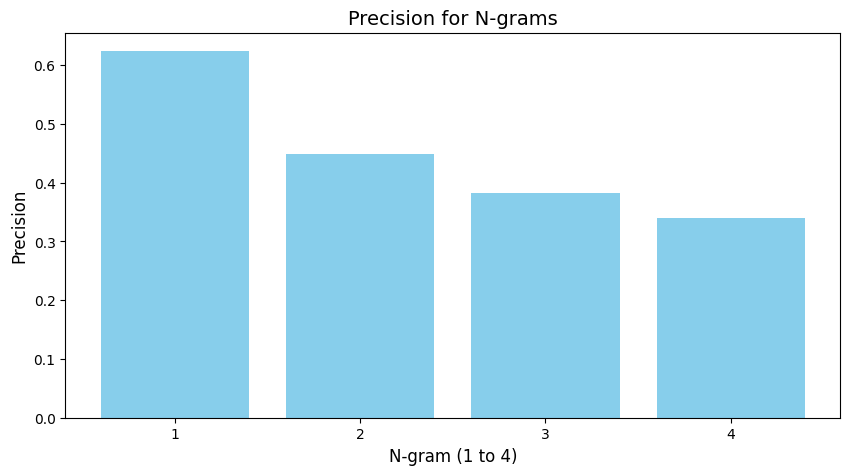

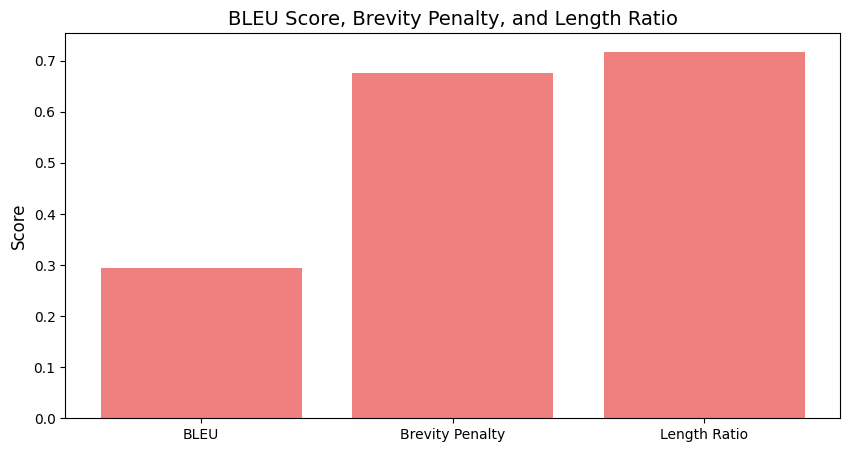

In [74]:
# Plotting the Precision values
plt.figure(figsize=(10, 5))
plt.bar(range(1, 5), bleu_results['precisions'], color='skyblue', label='Precision')
plt.xlabel('N-gram (1 to 4)', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision for N-grams', fontsize=14)
plt.xticks(range(1, 5))
plt.show()

# Plotting the BLEU score, brevity penalty, and length ratio
plt.figure(figsize=(10, 5))
labels = ['BLEU', 'Brevity Penalty', 'Length Ratio']
values = [bleu_results['bleu'], bleu_results['brevity_penalty'], bleu_results['length_ratio']]

plt.bar(labels, values, color='lightcoral')
plt.ylabel('Score', fontsize=12)
plt.title('BLEU Score, Brevity Penalty, and Length Ratio', fontsize=14)
plt.show()

# Advance RAG

In [75]:
from llama_index.core.indices.postprocessor import SentenceTransformerRerank, MetadataReplacementPostProcessor

def get_sentence_window_query_engine(
    sentence_index,
    similarity_top_k=10,
    rerank_top_n=5,
):
    # define postprocessors
    postproc = MetadataReplacementPostProcessor(target_metadata_key="window")
    rerank = SentenceTransformerRerank(
        top_n=rerank_top_n, model="BAAI/bge-reranker-base"
    )

    sentence_window_engine = sentence_index.as_query_engine(
        similarity_top_k=similarity_top_k, node_postprocessors=[postproc, rerank]
    )
    return sentence_window_engine

In [76]:
storage_context = StorageContext.from_defaults(
        persist_dir = "./embedding/sentence_index"
    )

vector_index = load_index_from_storage(
    storage_context, 
)

sentence_window_engine = get_sentence_window_query_engine(vector_index)

In [77]:
# records = tru_query_engine_recorder
answers_advance = []
for question in eval_questions:
    answers_advance.append(sentence_window_engine.query(question))

In [78]:
bleu_results = bleu.compute(predictions=[ref.response for ref in answers_advance], references=[[ref] for ref in correct_answer])

In [79]:
bleu_results

{'bleu': 0.5233614177535301,
 'precisions': [0.7366863905325444,
  0.5890547263681593,
  0.5040160642570282,
  0.45390070921985815],
 'brevity_penalty': 0.932375429676663,
 'length_ratio': 0.9345622119815669,
 'translation_length': 1014,
 'reference_length': 1085}

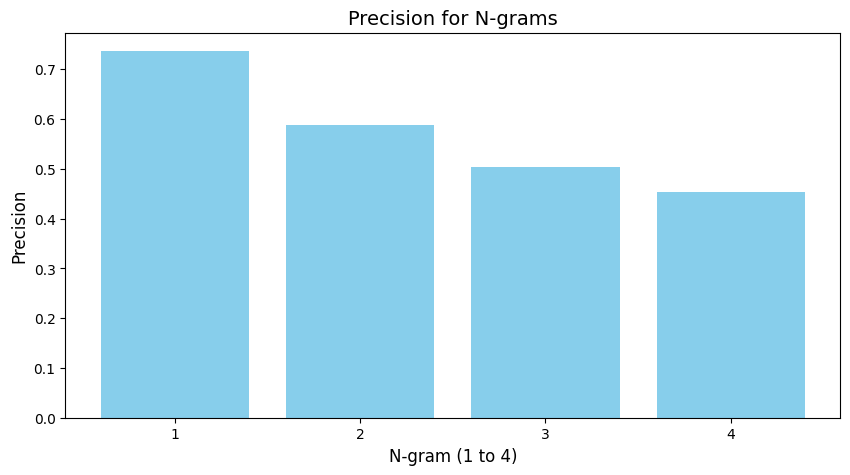

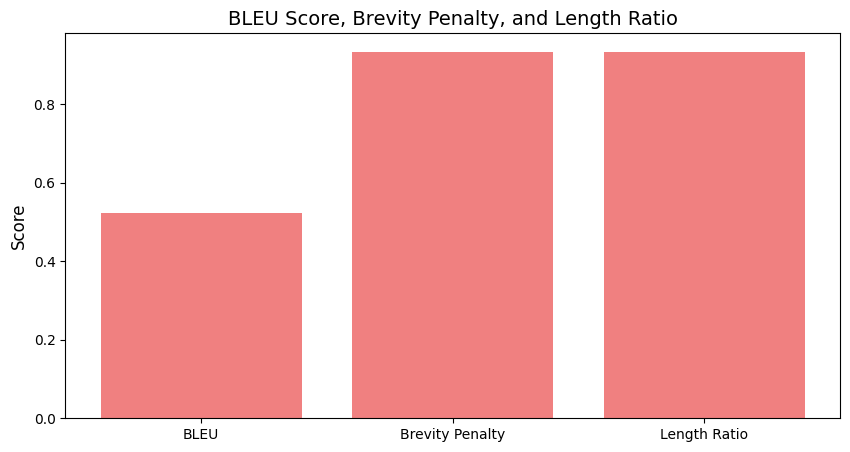

In [80]:
# Plotting the Precision values
plt.figure(figsize=(10, 5))
plt.bar(range(1, 5), bleu_results['precisions'], color='skyblue', label='Precision')
plt.xlabel('N-gram (1 to 4)', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision for N-grams', fontsize=14)
plt.xticks(range(1, 5))
plt.show()

# Plotting the BLEU score, brevity penalty, and length ratio
plt.figure(figsize=(10, 5))
labels = ['BLEU', 'Brevity Penalty', 'Length Ratio']
values = [bleu_results['bleu'], bleu_results['brevity_penalty'], bleu_results['length_ratio']]

plt.bar(labels, values, color='lightcoral')
plt.ylabel('Score', fontsize=12)
plt.title('BLEU Score, Brevity Penalty, and Length Ratio', fontsize=14)
plt.show()